<a href="https://colab.research.google.com/github/DinarSalpaAulia44/7-Stack/blob/main/Klasifikasi_kuaci.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [27]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import when
from pyspark.ml import Pipeline
from pyspark.ml.feature import (
    Tokenizer, StopWordsRemover, CountVectorizer, IDF,
    StringIndexer, OneHotEncoder, VectorAssembler, StandardScaler
)
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [28]:
# Inisialisasi SparkSession
spark = SparkSession.builder \
    .appName("ShopeeProductClassification") \
    .getOrCreate()

# Load data CSV
df = spark.read.csv("/content/kuaci1kg_cleaned.csv", header=True, inferSchema=True)

#tampilkan data
df.show(5)


+--------------------+------+--------------+---------+-----+
|         Nama Produk| Harga|        Alamat|penjualan|price|
+--------------------+------+--------------+---------+-----+
|Pumpkin Seed 1kg ...|89.999|Kab. Tangerang|     1800|89999|
|Roasted Organic S...| 10.99|        Cimahi|     5000| 1099|
|Organic Paradise ...|  23.2| Jakarta Utara|      757|  232|
|Mola Kuaci Kupas ...| 15.64|         Depok|      995| 1564|
|KUACI | KWACI PUT...| 107.0|         Medan|       72| 1070|
+--------------------+------+--------------+---------+-----+
only showing top 5 rows



In [29]:
# 1. Buat label klasifikasi berdasarkan kolom terjual
df = df.withColumn(
    "label",
    when(df.penjualan < 100, 0) \
    .when((df.penjualan >= 100) & (df.penjualan < 1000), 1) \
    .otherwise(2)
)

In [30]:
# 2. Transform Judul
tokenizer = Tokenizer(inputCol="Nama Produk", outputCol="words")
remover = StopWordsRemover(inputCol="words", outputCol="filtered_words")
vectorizer = CountVectorizer(inputCol="filtered_words", outputCol="rawFeatures")
idf = IDF(inputCol="rawFeatures", outputCol="title_features")

In [31]:
# 3. Transform Lokasi
tempat_indexer = StringIndexer(inputCol="Alamat", outputCol="tempat_index", handleInvalid="keep")
tempat_encoder = OneHotEncoder(inputCol="tempat_index", outputCol="tempat_encoded")

In [32]:
# 4. Scaling fitur harga
harga_assembler = VectorAssembler(inputCols=["Harga"], outputCol="harga_vec")
harga_scaler = StandardScaler(inputCol="harga_vec", outputCol="harga_scaled")

In [33]:
# 5. Gabungkan semua fitur menjadi vector features
feature_assembler = VectorAssembler(
    inputCols=["title_features", "tempat_encoded", "harga_scaled"],
    outputCol="features"
)

In [34]:
# 6. Definisikan model klasifikasi RandomForest
classifier = RandomForestClassifier(featuresCol="features", labelCol="label", seed=42)

In [35]:
# 7. Buat pipeline lengkap
pipeline = Pipeline(stages=[
    tokenizer,
    remover,
    vectorizer,
    idf,
    tempat_indexer,
    tempat_encoder,
    harga_assembler,
    harga_scaler,
    feature_assembler,
    classifier
])

In [36]:
# 8. Bagi data train-test split
train_df, test_df = df.randomSplit([0.8, 0.2], seed=42)

# 9. Latih model
model = pipeline.fit(train_df)

# 10. Prediksi di data test
predictions = model.transform(test_df)

In [37]:
# 11. Evaluasi akurasi
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print(f"Accuracy: {accuracy}")

Accuracy: 0.46153846153846156


In [39]:

# 12. Classification

# Tambahkan kolom label_name
predictions = predictions.withColumn(
    "label_name",
    when(predictions.label == 0, "Low") \
    .when(predictions.label == 1, "Medium") \
    .otherwise("High")
)

# (Opsional) Tambahkan juga prediksi label_name
predictions = predictions.withColumn(
    "predicted_label_name",
    when(predictions.prediction == 0, "Low") \
    .when(predictions.prediction == 1, "Medium") \
    .otherwise("High")
)

predictions.select("Nama Produk", "Harga", "penjualan","Alamat", "label_name", "prediction").show(100)

+--------------------+------+---------+------------------+----------+----------+
|         Nama Produk| Harga|penjualan|            Alamat|label_name|prediction|
+--------------------+------+---------+------------------+----------+----------+
|1kg RAW Sunflower...|  47.9|      889|          Surabaya|    Medium|       1.0|
|500gr Biji Bunga ...|  31.0|       91|           Bandung|       Low|       1.0|
|Cemilan Kuaci Bij...|99.999|      253|          Surabaya|    Medium|       1.0|
|KUACI PUTIH 500 G...|45.999|      904|     Jakarta Pusat|    Medium|       1.0|
|Kuaci Bunga Matah...|  9.99|      920|         Tangerang|    Medium|       1.0|
|Kuaci Rebo Kiloan...|49.999|      724|    Kab. Sukoharjo|    Medium|       0.0|
|Kwaci Super Bunga...|  90.0|       38|          Surabaya|       Low|       1.0|
|Organic Raw Sunfl...|  45.0|      997|    Kab. Tangerang|    Medium|       1.0|
|Raw Sunflower See...|  45.5|     2200|Kab. Bandung Barat|      High|       1.0|
|Rebo Kuaci Rasa O...|   8.2

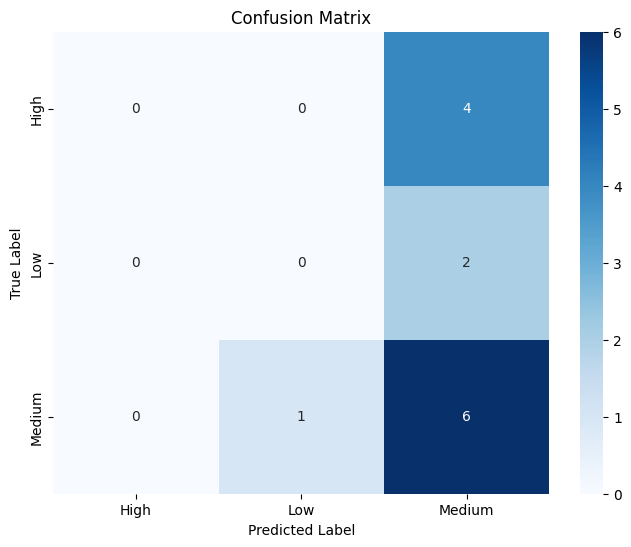

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Konversi DataFrame PySpark ke Pandas
# Pilih kolom yang relevan untuk confusion matrix
pandas_df = predictions.select("label_name", "prediction").toPandas()

# Konversi kolom 'prediction' menjadi string agar sesuai dengan tipe data 'label_name'
# Gunakan mapping yang sama seperti saat membuat 'predicted_label_name'
pandas_df['prediction'] = pandas_df['prediction'].apply(
    lambda x: 'Low' if x == 0 else ('Medium' if x == 1 else 'High')
)


# Confusion Matrix
# Gunakan string labels untuk kedua argumen
cm = confusion_matrix(pandas_df['label_name'], pandas_df['prediction'])
# Dapatkan unique labels dari kolom string
labels = sorted(pandas_df['label_name'].unique())

# Visualisasi Confusion Matrix
plt.figure(figsize=(8, 6))
# Pastikan order label di heatmap sama dengan order di confusion matrix
sns.heatmap(cm, annot=True, fmt='d', xticklabels=labels, yticklabels=labels, cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

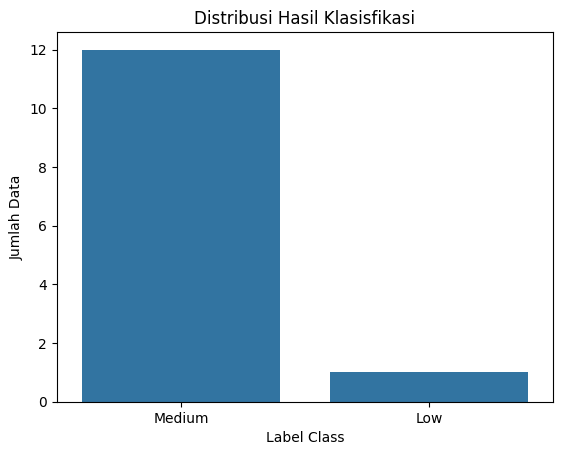

In [41]:
sns.countplot(x="prediction", data=pandas_df)
plt.title("Distribusi Hasil Klasisfikasi")
plt.xlabel("Label Class")
plt.ylabel("Jumlah Data")
plt.show()

In [43]:
save = predictions.select("Nama Produk", "Harga", "penjualan","Alamat", "label_name", "prediction")
save.write.csv("predictions.csv", header=True)